In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
import os
from copy import deepcopy

def get_markers(adata_log, topk='all', genetype='up', if_clean=True):
    markers = {}
    markers_list = []
    for celltype in adata_log.obs['celltype2'].unique():
        gene_names = adata_log.uns['rank_genes_groups']['names'][celltype]
        pvals_adj = adata_log.uns['rank_genes_groups']['pvals_adj'][celltype]
        logfc = adata_log.uns['rank_genes_groups']['logfoldchanges'][celltype]

        sort_index = np.argsort(pvals_adj)
        
        gene_names = gene_names[sort_index]
        pvals_adj = pvals_adj[sort_index]
        logfc = logfc[sort_index]
        
        if genetype == 'up':
            celltype_markers = gene_names[(pvals_adj < 0.05) & (logfc > 0.25)]
        elif genetype == 'up&down':
            celltype_markers = gene_names[(pvals_adj < 0.05) & (np.abs(logfc) > 0.25)]
            
        if topk != 'all':
            celltype_markers = celltype_markers[0:topk]
    
        # print(len(celltype_markers))
        markers_list.extend(celltype_markers.tolist())
        markers[celltype] = celltype_markers.tolist()

    markers_list = list(set(markers_list))
    print('markers_before_clean:', len(markers_list))

    markers_set = deepcopy(markers)
    if if_clean:
        markers = clean_markers(markers)
        markers_set = deepcopy(markers)
        markers = markers_set_to_list(markers)
        print('markers_after_clean:', len(markers))
    else:
        markers = markers_set_to_list(markers)
    return markers, markers_set

def clean_markers(markers):
    markers_clean = markers.copy()
    from functools import reduce
    for celltype in markers.keys():
        marker_set_celltype = set(markers[celltype])
        other_celltypes = set(markers.keys()) - set([celltype])
        marker_set_other_celltypes = reduce(lambda x,y: x.union(y), [set(markers[ct]) for ct in other_celltypes])
        markers_clean[celltype] = list(marker_set_celltype - marker_set_other_celltypes)
    return markers_clean

def markers_set_to_list(markers):
    markers_list = []
    for celltype in markers.keys():
        markers_list.extend(markers[celltype])
    return markers_list

def get_signature_matrix(adata_norm, markers):
    adata_proc = adata_norm[:, markers].copy()
    # to normed data
    adata_proc.X = np.exp(adata_proc.X.toarray()) - 1
    
    selections = np.isin(adata_proc.var_names, markers)
    
    clusters = adata_proc.obs['celltype2'].unique()
    sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
    for cluster in clusters:
        cells = adata_proc.obs['celltype2'] == cluster
        sc_part = adata_proc[cells,:].X.T
        sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    
    return sc_mean.T, selections


In [2]:
# load scRNA-seq data
sc_adata_0 = sc.read_h5ad("../Datasets/adata/panage_pbmc_filter.h5ad")
sc_adata = sc.AnnData(X=sc_adata_0.raw.X, obs=sc_adata_0.obs, var=sc_adata_0.raw.var)
del sc_adata_0

In [3]:
# find markers
# adata_log = sc_adata.copy()
# sc.tl.rank_genes_groups(adata_log, 'celltype2', method='wilcoxon')
data_path = '../Datasets/adata/'
# sc.write(os.path.join(data_path, 'adata_log.h5ad'), adata_log)
adata_log = sc.read(os.path.join(data_path, 'adata_log.h5ad'))

In [6]:
markers, markers_set = get_markers(adata_log, topk='all', genetype='up&down', if_clean=True)
markers_df = pd.DataFrame(columns=['gene'])
for key in markers_set.keys():
    genes = markers_set[key]
    tmp_df = pd.DataFrame(genes, columns=['gene'])
    tmp_df['celltype'] = key
    markers_df = pd.concat([markers_df, tmp_df], axis=0)

# markers_df = pd.DataFrame(markers)
markers_df.to_csv(os.path.join('../results/', 'markers_with_celltypes.csv'), index=False, header=False)
markers_df

markers_before_clean: 11363
markers_after_clean: 1519


,gene,celltype
0,SPSB2,CD4_TCM
1,SARDH,CD4_TCM
2,NKD1,CD4_TCM
3,AC098484.3,CD4_TCM
4,BICRAL,CD4_TCM
...,...,...
5,ATAD3B,CD83_B
6,NIPAL4,CD83_B
7,FAM83G,CD83_B
8,POLR1B,CD83_B


In [ ]:

# get signature matrix and selections
signature, selections = get_signature_matrix(sc_adata, markers)
signature_info = {'signature': signature, 'selections': selections}
pickle.dump(signature_info, open(os.path.join('./model/deconv/', 'signature_info.pkl'), 'wb'))

In [12]:
markers_df = pd.DataFrame(markers)
markers_df.to_csv(os.path.join('../results/', 'markers.csv'), index=False, header=False)
markers_df

,0
0,GCNT4
1,FAM184A
2,SFXN2
3,TRBV6-6
4,VPS33A
...,...
1514,TRIM39
1515,NIPAL4
1516,TVP23A
1517,POLR1B


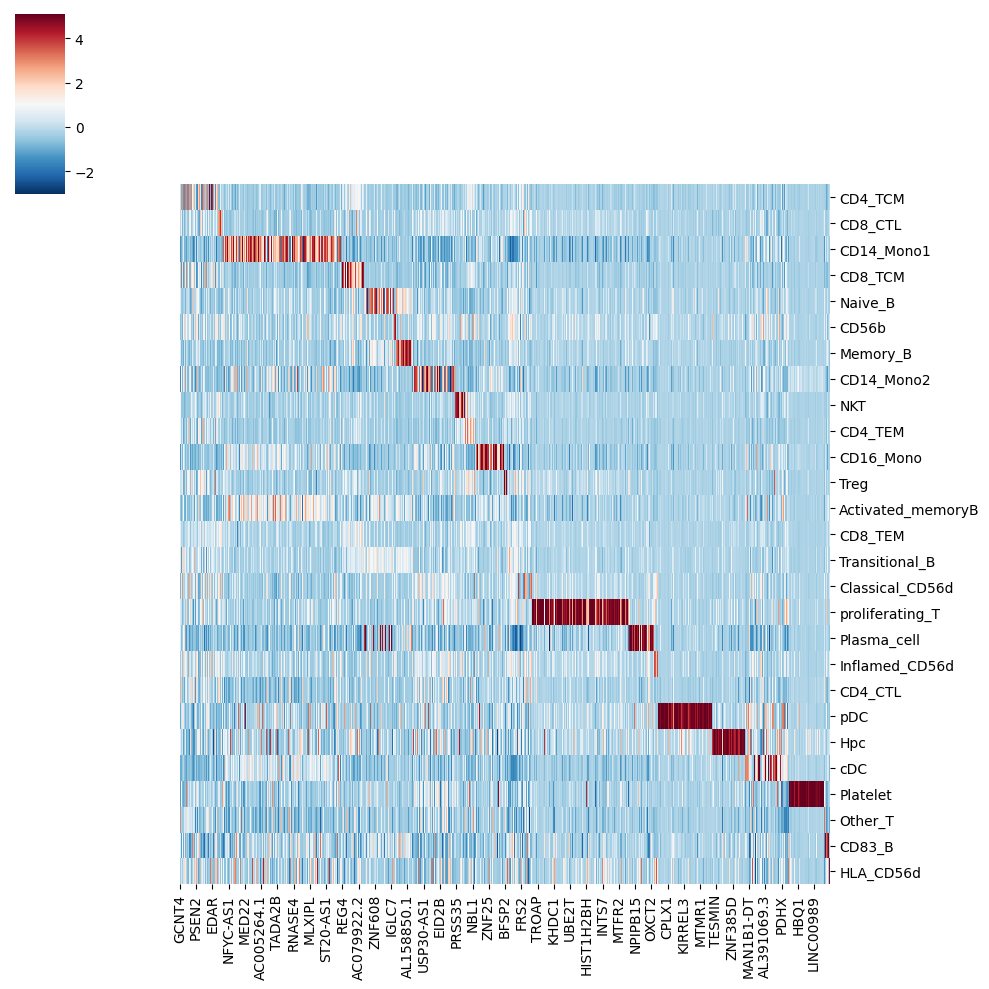

In [11]:
import seaborn as sns
a = np.log(signature + 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
a = pd.DataFrame(scaler.fit_transform(a), index=a.index, columns=a.columns) 

sns.clustermap(a.loc[adata_log.obs['celltype2'].unique(), markers], method='average', metric='euclidean', col_cluster=False, row_cluster=False, cmap='RdBu_r')

import matplotlib.pyplot as plt
plt.savefig('../results/marker_heatmap.pdf')

bulk_test: (20735, 10)
deconvoluting bulk data...
predicting...
done.
bulk_test: (25280, 11)
deconvoluting bulk data...
predicting...
done.
Results on test set:
             Predicted age  Actual age
H10              64.392686          61
H1               63.934857          65
H2               62.118206          56
H3               64.392686          74
H4               66.424422          56
H5               29.566977          53
H6               62.986501          57
H7               65.381927          74
H8               73.986215          64
H9               64.110846          71
DK20193B_01      36.815532          42
DK20193B_02      41.350555          31
DK20193B_03      37.167010          34
DK20193B_04      78.387738          58
DK20193B_05      44.507941          45
DK20193B_06      52.463789          46
DK20193B_07      37.129197          48
DK20193B_08      69.890101          43
DK20193B_09      50.206703          66
DK20193B_10      33.517027          37
DK20193B_11      42.

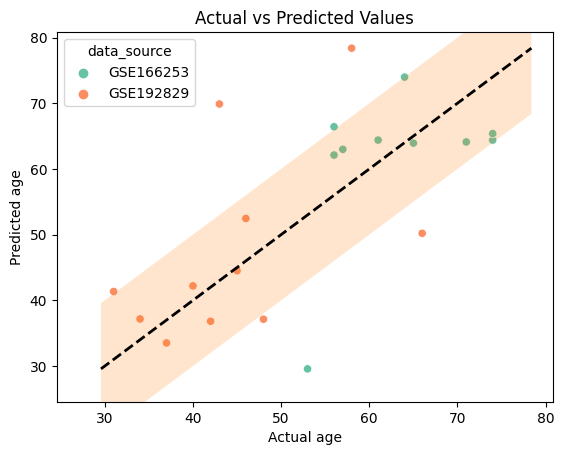

In [16]:
#%%
from .immAGE import *
from .utils import *

#%% load the test bulk tpm data
# data_names = ["GSE166253", 
#               "GSE192829", 
#               "GSE198533",
#               "GSE180081"]

data_names = ["GSE166253", 
            "GSE192829"]

compare_all = pd.DataFrame()   
for data_name in data_names:
    # data_name = "GSE192829"
    bulk_test =  pd.read_csv(os.path.join('../Datasets/', 'bulk', f'{data_name}_tpm.csv'), index_col=0)  
    print('bulk_test:', bulk_test.shape)

    ## %% predict the age of the test set
    immage = load_model(save_dir='./model/fast')
    immage.fast_annotation = True
    pred_test = immage.predict_bulk(bulk_test, deconv_method='nnls')
    # print(pred_test["predicted_Age"])

    ##%% evaluate the prediction
    meta_test = pd.read_csv(f'../Datasets/bulk/{data_name}_clinical.csv', index_col=0)
    meta_test = meta_test.loc[bulk_test.columns, :]
    test_sample_labels = meta_test['age']

    compare = pd.concat([pred_test["predicted_Age"], test_sample_labels], axis=1)
    compare.columns = ['Predicted age', 'Actual age']
    
    compare['data_source'] = data_name
    celltype_percentage = pred_test.drop(columns=['predicted_Age'])
    compare = pd.concat([compare, celltype_percentage], axis=1)
    
    # print('Results on test set:')
    # print(compare)
    
    compare_all = pd.concat([compare_all, compare], axis=0)
    
print('Results on test set:')
print(compare_all[['Predicted age', 'Actual age']]) 
eval_prediction(compare_all['Actual age'], compare_all['Predicted age'])
plot_pred_results(compare_all, band_width=10, save_path='../results/bulk_prediction.pdf')
compare_all.to_csv('../results/bulk_prediction.csv')
